In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# Load the dataset
data = pd.read_csv('/content/Kosi Rainfall + metrics daily (2014-2023).csv')

# Extract relevant columns
parameters = ['PRECTOTCORR', 'WS10M', 'RH2M', 'QV2M', 'T2M_RANGE', 'ALLSKY_SFC_UV_INDEX']
data = data[parameters]

# Normalize the features
scalers = {}
for param in parameters:
    scalers[param] = MinMaxScaler()
    data[param] = scalers[param].fit_transform(data[param].values.reshape(-1, 1))

# Create sequences
def create_sequences(data, seq_length):
    sequences = []
    targets = []
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i+seq_length])
        targets.append(data[i+seq_length])
    return np.array(sequences), np.array(targets)

SEQ_LENGTH = 30  # You can adjust the sequence length
X, y = create_sequences(data.values, SEQ_LENGTH)

# Split the data into training and testing sets
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]





In [2]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout

model = Sequential([
    Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(SEQ_LENGTH, len(parameters))),
    MaxPooling1D(pool_size=2),
    LSTM(100, return_sequences=True),
    Dropout(0.2),
    LSTM(50),
    Dense(len(parameters))
])

model.compile(optimizer='adam', loss='mse')
model.summary()






Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 28, 64)            1216      
                                                                 
 max_pooling1d (MaxPooling1  (None, 14, 64)            0         
 D)                                                              
                                                                 
 lstm (LSTM)                 (None, 14, 100)           66000     
                                                                 
 dropout (Dropout)           (None, 14, 100)           0         
                                                                 
 lstm_1 (LSTM)               (None, 50)                30200     
                                                                 
 dense (Dense)               (None, 6)                 306       
                                                        

In [5]:
history = model.fit(X_train, y_train, epochs=30, batch_size=32, validation_data=(X_test, y_test))



Epoch 1/30
91/91 [==============================] - 2s 26ms/step - loss: 0.0086 - val_loss: 2385.9307
Epoch 2/30
91/91 [==============================] - 2s 26ms/step - loss: 0.0082 - val_loss: 2386.1582
Epoch 3/30
91/91 [==============================] - 3s 37ms/step - loss: 0.0079 - val_loss: 2386.3027
Epoch 4/30
91/91 [==============================] - 3s 28ms/step - loss: 0.0077 - val_loss: 2386.7615
Epoch 5/30
91/91 [==============================] - 2s 26ms/step - loss: 0.0076 - val_loss: 2386.4573
Epoch 6/30
91/91 [==============================] - 2s 26ms/step - loss: 0.0077 - val_loss: 2386.5894
Epoch 7/30
91/91 [==============================] - 2s 25ms/step - loss: 0.0074 - val_loss: 2386.0730
Epoch 8/30
91/91 [==============================] - 3s 34ms/step - loss: 0.0074 - val_loss: 2386.2498
Epoch 9/30
91/91 [==============================] - 3s 34ms/step - loss: 0.0073 - val_loss: 2386.3079
Epoch 10/30
91/91 [==============================] - 2s 26ms/step - loss: 0.0072 -

In [6]:
# Predict on the test data
y_pred = model.predict(X_test)

# Inverse transform the predictions
for i, param in enumerate(parameters):
    y_test[:, i] = scalers[param].inverse_transform(y_test[:, i].reshape(-1, 1)).reshape(-1)
    y_pred[:, i] = scalers[param].inverse_transform(y_pred[:, i].reshape(-1, 1)).reshape(-1)

# Calculate metrics
metrics = {}
for i, param in enumerate(parameters):
    mse = mean_squared_error(y_test[:, i], y_pred[:, i])
    mae = mean_absolute_error(y_test[:, i], y_pred[:, i])
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test[:, i], y_pred[:, i])
    metrics[param] = {'MSE': mse, 'MAE': mae, 'RMSE': rmse, 'R2': r2}

# Print metrics
for param, metric in metrics.items():
    print(f"{param} - MSE: {metric['MSE']}, MAE: {metric['MAE']}, RMSE: {metric['RMSE']}, R2: {metric['R2']}")




23/23 [==============================] - 0s 12ms/step
PRECTOTCORR - MSE: 782087.0728020027, MAE: 331.74488184940134, RMSE: 884.356869596207, R2: -0.15433536264360903
WS10M - MSE: 1174.6258983843854, MAE: 31.2918944990654, RMSE: 34.27281573469541, R2: -4.623041336758417
RH2M - MSE: 32060833.545570794, MAE: 5393.21348588245, RMSE: 5662.228673020085, R2: -9.549112007490123
QV2M - MSE: 92972.86989198544, MAE: 278.37270746073017, RMSE: 304.91452883059776, R2: -4.471068841227417
T2M_RANGE - MSE: 57879.034987599705, MAE: 226.07940357556993, RMSE: 240.58062055701765, R2: -6.873949738858258
ALLSKY_SFC_UV_INDEX - MSE: 9699075958.006948, MAE: 10290.719036985027, RMSE: 98483.88679376413, R2: -0.008885882829534397


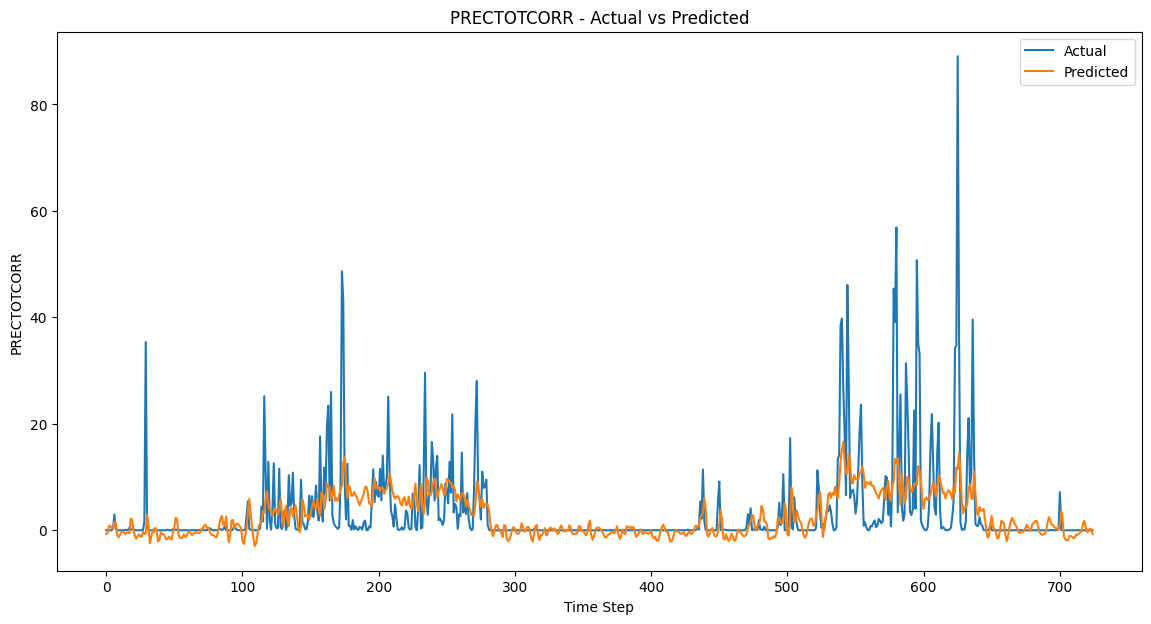

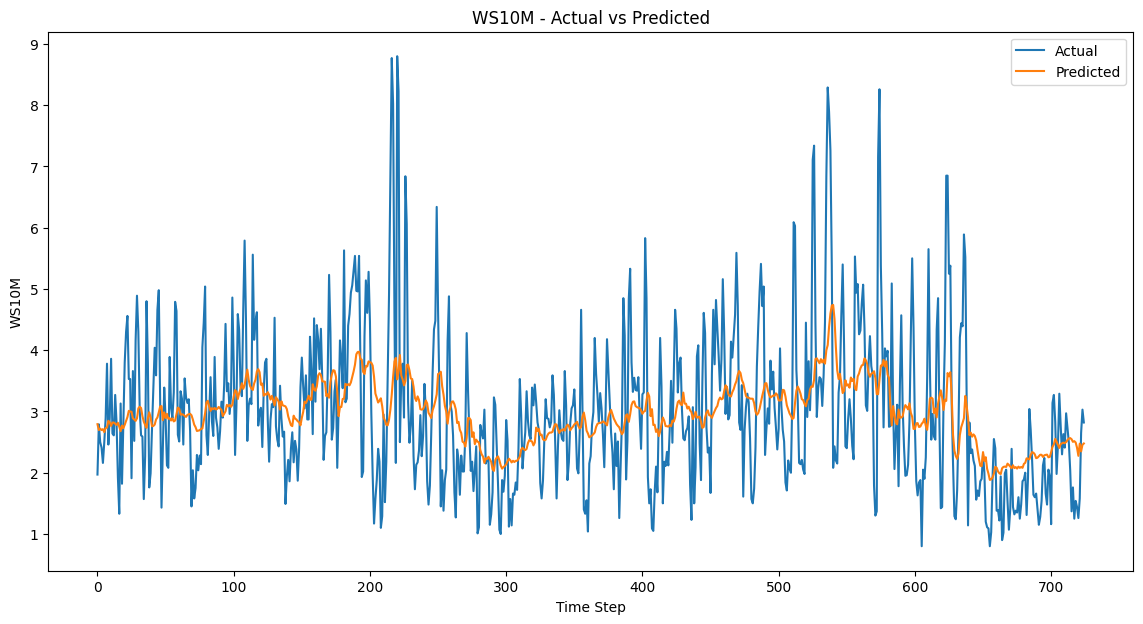

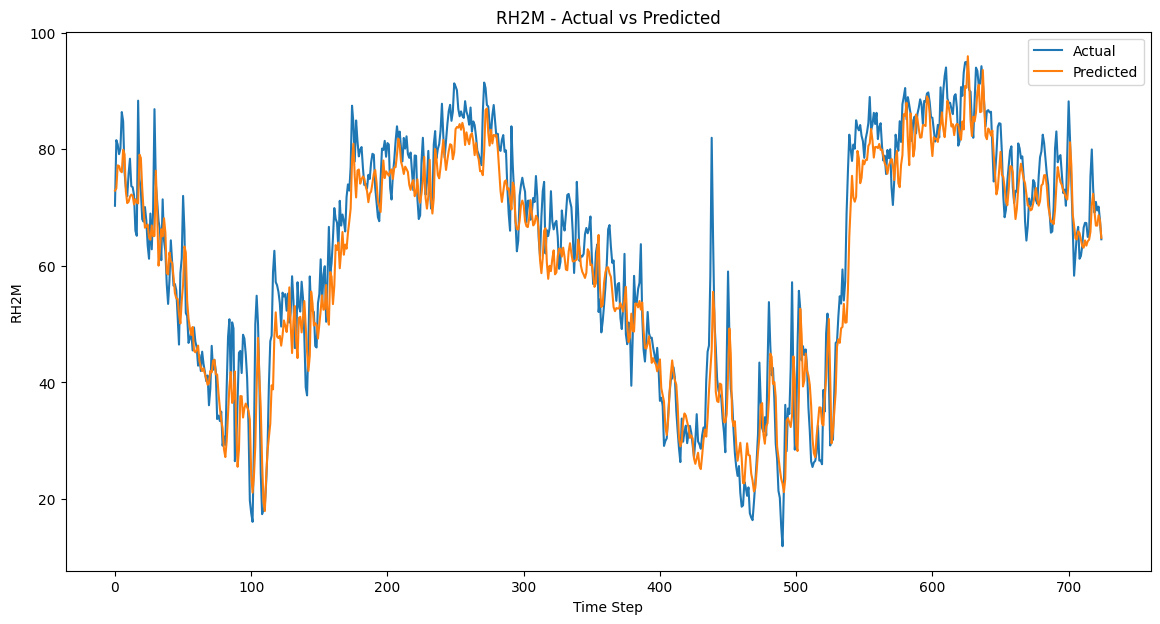

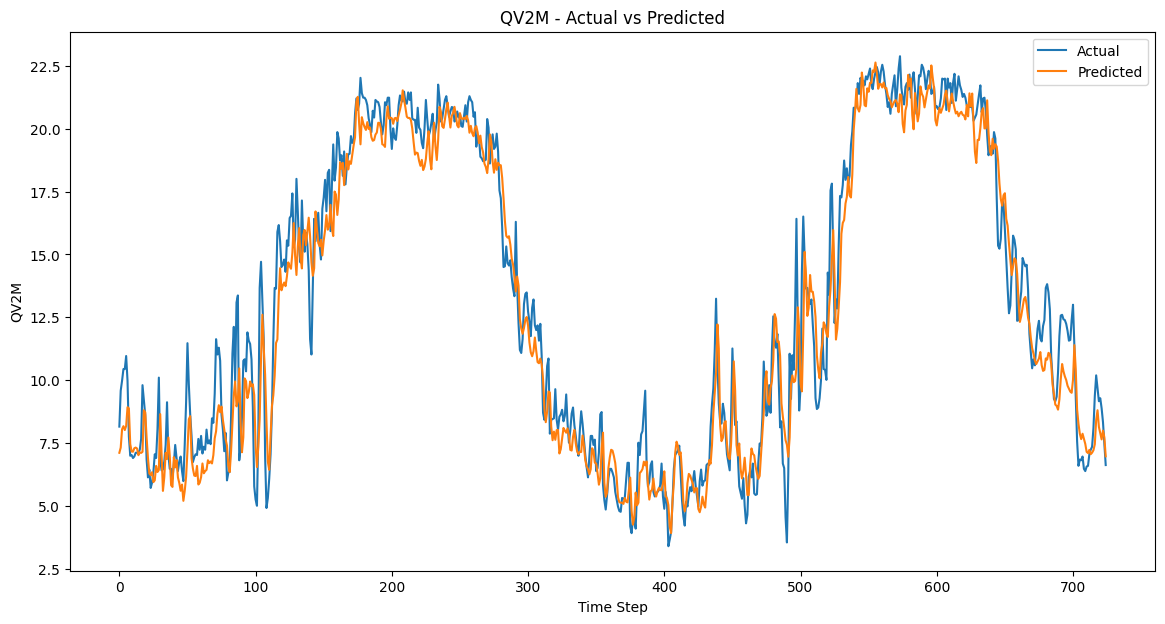

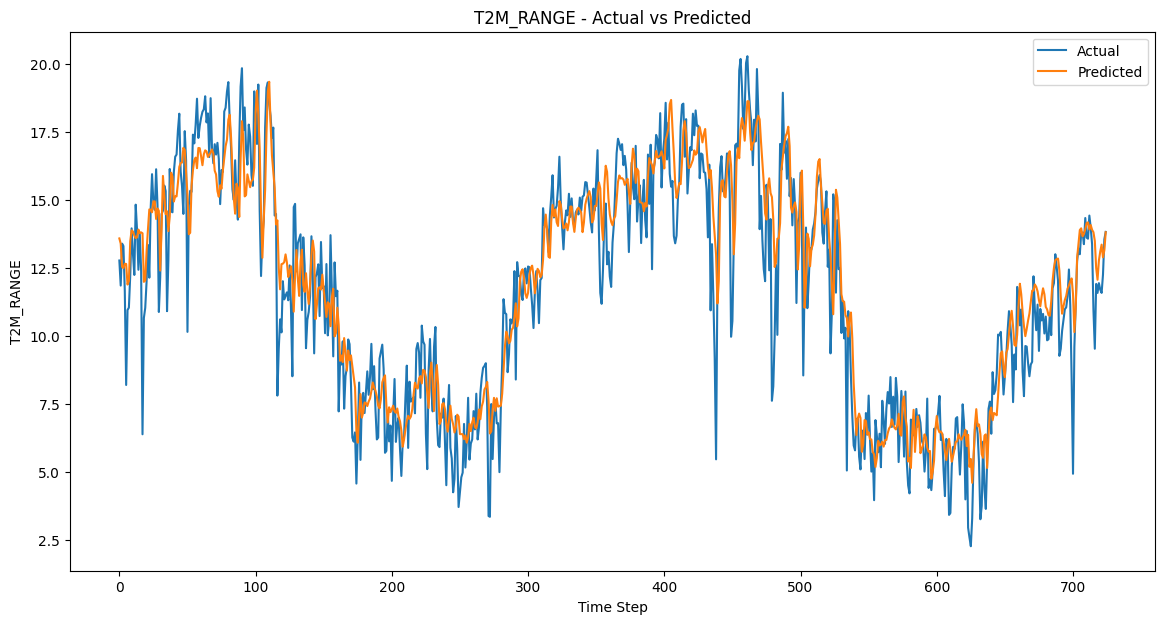

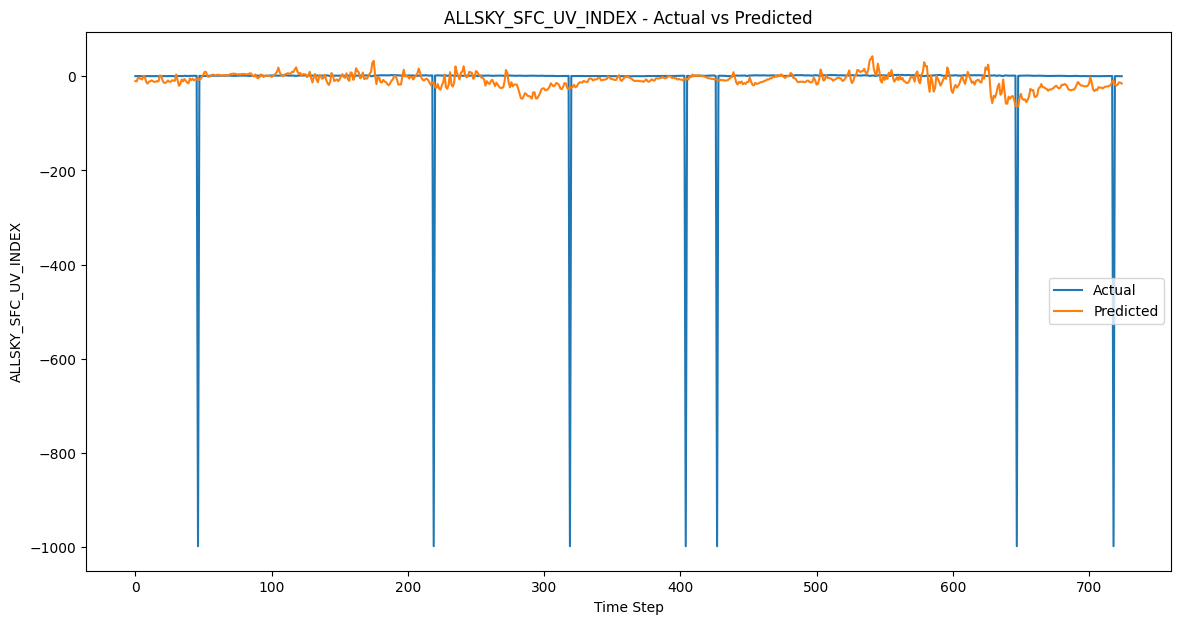

In [ ]:
for i, param in enumerate(parameters):
    plt.figure(figsize=(14, 7))
    plt.plot(y_test[:, i], label='Actual')
    plt.plot(y_pred[:, i], label='Predicted')
    plt.title(f"{param} - Actual vs Predicted")
    plt.xlabel('Time Step')
    plt.ylabel(param)
    plt.legend()
    plt.show()

